# Longwave Radiation

__J. Potemra__
<br>
_May 2024_



Longwave radiation, also referred to as infrared radiation or IR, is the (typically) cooling component of radiative heat flux (incoming shortwave typically being the heating component).  Longwave radiation, at some level, is relatively straightforward to calculate as it is a function of temperature.  All bodies emit longwave radiation merely by having a temperature.  The relationship is given by:

\begin{eqnarray}
Q_{L} = \epsilon \sigma T^{4}
\end{eqnarray}

where $\epsilon$ is the emissivity and $\sigma$ is the Stefan Boltzmann constant ($5.67 x 10^{-8} \: W/m^{2}/K^{4}$).

For the ocean surface, the appropriate temperature is the "bulk surface temperature" although some calculations are made using the upper "skin" temperature, and others use simply the sea surface temperature (SST) as that is more easily measured.  Emissivity for sea water is close to 0.97, thus simplifying the equation above to a constant times temperature to the fourth power.  

There are two components to consider when computing the net longwave heat at the ocean surface.  One is the downward longwave heat emitted by the atmosphere, $Q_{L}^{Down}$, the other is the heat loss by the surface of the ocean, $Q_{L}^{Up}$.  Of the atmospheric downward longwave radiation that reaches the ocean surface, part is absorbed by the ocean ($\epsilon Q_{L}^{Down}$) and the rest is emitted back ($(1-\epsilon) Q_{L}^{Down}$).  The moorings typically measure the downward longwave radiation directly, then use ocean temperature to calculate the upward, then the net longwave is simply the difference.

<figure>
   <img src="./images/longwave_cartoon.jpg" style="width:50%">
   <figcaption align = "center">Figure 1.  Schematic of outgoing longwave radiation. </figcaption>
</figure>
<br>

The net longwave heat flux at the ocean surface in the downward direction (positive down) is computed as:

\begin{eqnarray}
Q_{L}^{Net} = Q_L^{Down} - Q_L^{Up}
\end{eqnarray}
    
$Q_L^{Up}$ includes both the longwave emitted as black body ($\epsilon \sigma T_{SST}^4$), but __also__ the longwave radition emitted from the atmosphere that is reflected by the ocean, $(1-\epsilon)Q_L^{Down}$.  Therefore,

\begin{eqnarray}
    Q_L^{Down} = Q_L^{Down} \\
    Q_L^{Up} = (1-\epsilon) Q_L^{Down} + \epsilon \sigma T_{SST}^4
\end{eqnarray}

<br>
and $Q_L^{Net}$ is then,
<br>
    
\begin{eqnarray}
    Q_L^{Net} = Q_L^{Down} - Q_L^{Up} \\
    Q_L^{Net} = Q_L^{Down} - \left[ (1-\epsilon) Q_L^{Down} + \epsilon \sigma T_{SST}^4 \right]\\
    Q_L^{Net} = Q_L^{Down} \left[ 1 - ( 1 - \epsilon ) \right] - \epsilon \sigma T_{SST}^4 \\
    Q_L^{Net} = \epsilon \left[ Q_L^{Down} - \sigma T_{SST}^4 \right]
\end{eqnarray}

The downward longwave is measured by the mooring directly (note, the variable in the ORS file is $lwr$), and the upward is computed using the skin temperature ($tskin$ in the ORS files).  The ORS files also provide the computed net downward longwave radiation ($Ql$).

<font color=red>
Notes:
    
 1. The ORS files have measured $Q_L^{Down}$ as _lwr_ in the MLTS files, whereas $Q_L^{Net}$ is given in the FLTS files as _Ql_.  The FLTS files also have skin temperature as _tskin_.  Therefore, the equations above become
    
\begin{eqnarray}
    Ql = \epsilon \left[ lwr - \sigma \: tskin^4 \right] \\
    Q_L^{Up} = (1-\epsilon) \: lwr + \epsilon \: \sigma \: tskin^4 \\
    Q_L^{Up} = lwr - Ql
\end{eqnarray}
    
 2. The CFS model uses _ulwsfc_ for $Q_L^{Up}$ and _dlwsfc_ for $Q_L^{Down}$.
 
 3. In C. Fairall's matlab scripts, he uses _rln_ for $Q_L^{Net}$ and _rl_ for $Q_L^{Down}$.
    
 4. Also in Chris' code he computes downward longwave from the net longwave (I'm not sure why he does not read it directly from the mooring data):
    
     rl=rln/0.97+5.67e-8*(ts+tdk).^4

Here, _rl_ is downward longwave, _rln_ is net longwave (read in from file), and _ts_ is skin SST.

</font>

In this notebook we first look at the characteristics of longwave radiation as measured by the three Ocean Reference Station (ORS) sites.  Next, we compare the different components (up and down) to the operational coupled climate model CFSv2.  Finally, we use the longwave radiation as measured to estimate clould cover.

In [1]:
# import necessary packages
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import datetime, timedelta

# 1. Read in data for a specific ORS Site

In [2]:
site = 'WHOTS'
#site = 'Stratus'
#site = 'NTAS'
res = 'hourly'
#res = 'daily'

In [6]:
# 1. Read obs from local files: hourly files
if res == 'hourly':
    # WHOTS
    if site == 'WHOTS':
        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_flux_1hr.mat',
                       squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to9_best_met_1hr.mat',
                       squeeze_me=True)
        lat = fin1['lat'][0]
        lon = fin1['lon'][0]
        data = fin1['mday']
        time = data
        data = fin1['Ql']
        Ql = data
        data = fin1['tskin']
        tskin = data
        data = fin1['qq_h']
        qa = data
        data = fin1['ta_h']
        tair1 = data
        data = fin2['atmp']
        tair2 = data
        data = fin2['sst']
        sst = data
        data = fin2['bpr']
        press = data
        data = fin2['lwr']
        lwr = data
    
        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_flux_1hr.mat',squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots10_met_1hr.mat',squeeze_me=True)
        data = fin1['mday']
        time = np.append ( time, data[82:] )
        data = fin1['Ql']
        Ql = np.append ( Ql, data[82:] )
        data = fin1['tskin']
        tskin = np.append ( tskin, data[82:] )
        data = fin1['qq_h']
        qa = np.append ( qa, data[82:] )
        data = fin1['ta_h']
        tair1 = np.append ( tair1, data[82:] )
        data = fin2['atmp']
        tair2 = np.append ( tair2, data[82:] )
        data = fin2['sst']
        sst = np.append ( sst, data[82:])
        data = fin2['bpr']
        press = np.append ( press, data[82:] )
        data = fin2['lwr']
        lwr = np.append ( lwr, data[82:] )

        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_flux_1hr.mat',squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots11_met_1hr.mat',squeeze_me=True)
        data = fin1['mday']
        time = np.append ( time, data[84:] )
        data = fin1['Ql']
        Ql = np.append ( Ql, data[84:] )
        data = fin1['tskin']
        tskin = np.append ( tskin, data[84:] )
        data = fin1['qq_h']
        qa = np.append ( qa, data[84:] )
        data = fin1['ta_h']
        tair1 = np.append ( tair1, data[84:] )
        data = fin2['atmp']
        tair2 = np.append ( tair2, data[84:] )
        data = fin2['sst']
        sst = np.append ( sst, data[84:])
        data = fin2['bpr']
        press = np.append ( press, data[84:] )
        data = fin2['lwr']
        lwr = np.append ( lwr, data[84:] )

        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_flux_1hr.mat',squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots12_met_1hr.mat',squeeze_me=True)
        data = fin1['mday']
        time = np.append ( time, data[60:] )
        data = fin1['Ql']
        Ql = np.append ( Ql, data[60:] )
        data = fin1['tskin']
        tskin = np.append ( tskin, data[60:] )
        data = fin1['qq_h']
        qa = np.append ( qa, data[60:] )
        data = fin1['ta_h']
        tair1 = np.append ( tair1, data[60:] )
        data = fin2['atmp']
        tair2 = np.append ( tair2, data[60:] )
        data = fin2['sst']
        sst = np.append ( sst, data[60:])
        data = fin2['bpr']
        press = np.append ( press, data[60:] )
        data = fin2['lwr']
        lwr = np.append ( lwr, data[60:] )

        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_flux_1hr.mat',squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots13_met_1hr.mat',squeeze_me=True)
        data = fin1['mday']
        time = np.append ( time, data[54:] )
        data = fin1['Ql']
        Ql = np.append ( Ql, data[54:] )
        data = fin1['tskin']
        tskin = np.append ( tskin, data[54:] )
        data = fin1['qq_h']
        qa = np.append ( qa, data[54:] )
        data = fin1['ta_h']
        tair1 = np.append ( tair1, data[54:] )
        data = fin2['atmp']
        tair2 = np.append ( tair2, data[54:] )
        data = fin2['sst']
        sst = np.append ( sst, data[54:])
        data = fin2['bpr']
        press = np.append ( press, data[54:] )
        data = fin2['lwr']
        lwr = np.append ( lwr, data[54:] )
    
        otime = pd.date_range('2004-08-13 04:30:00', '2017-07-31 15:30:00', freq='H')

    # Stratus
    if site == 'Stratus':
        fin = loadmat('/Users/jimp/Desktop/whoi/obs/data/str1to10_best_flux_1hr.mat',
                      squeeze_me=True)
        lat = fin['lat'][0]
        lon = fin['lon'][0]
        Ql = fin['Ql']
        Ql = data
        data = fin1['sst']
        sst = data
        data = fin['mday']
        time = data

        fin = loadmat('/Users/jimp/Desktop/whoi/obs/data/str11to14_best_flux_1hr.mat',
                      squeeze_me=True)
        data = fin['Ql']
        Ql = np.append ( Ql, data )
        data = fin1['sst']
        sst = np.append ( sst, data )
        data = fin['mday']
        time = np.append ( time, data )

    # NTAS
    if site == 'NTAS':
        Ql = np.array(fin1.variables['QL'])
        fin1 = Dataset('/disk/whoi_sub/whoi/ntas/OS_NTAS_2001-2012_D_FLTS-1hr.nc', 'r')
        lat = fin1.variables['lat'][0]
        lon = fin1.variables['lon'][0]
        data = np.array(fin1.variables['QL'])
        Ql =  data
        data = np.array(fin1.variables['TIME'])
        time = data

        fin1 = Dataset('/disk/whoi_sub/whoi/ntas/OS_NTAS_2012-2014_D_FLTS-1hr.nc', 'r')
        data = np.array(fin1.variables['QL'])
        Ql = Ql.append ( data, ignore_index = True )
        data = np.array(fin1.variables['TIME'])
        time = time.append ( data, ignore_index = True )
    
        time = pd.to_datetime(time, unit='d', origin = pd.Timestamp('1950-01-01 00:00:00'))

In [7]:
# 1. Read obs from local files: daily files
if res == 'daily':

    if site == 'WHOTS':
        # first day: August 14, 2004
        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to15_best_flux_1d.mat',
                      squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/whots1to15_best_met_1d.mat',
                      squeeze_me=True)
    if site == 'NTAS':
        # first day March 31, 2001
        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/ntas1to18_best_flux_1d.mat',
                      squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/ntas1to18_best_met_1d.mat',
                      squeeze_me=True)
    if site == 'Stratus':
        # first day: October 9, 2000
        fin1 = loadmat('/Users/jimp/Research/whoi/obs/data/str1to18_best_flux_1d.mat',
                      squeeze_me=True)
        fin2 = loadmat('/Users/jimp/Research/whoi/obs/data/str1to18_best_met_1d.mat',
                      squeeze_me=True)

    lat = fin1['lat'][0]
    lon = fin1['lon'][0]
    iday = fin1['yday']
    iyear = fin1['year']
    date1 = str(iyear-1) + '-12-31'
    otime = pd.to_datetime(iday*24.0, unit='h', origin = pd.Timestamp(date1))
    Ql = fin1['Ql']
    sst = fin2['sst']
    tskin = fin1['tskin']
    tair1 = fin1['ta_h']
    tair2 = fin2['atmp']
    qa = fin1['qq_h']
    press = fin2['bpr']
    lwr = fin2['lwr']

In [8]:
# load CFSv2 data; note the model provides both up- and downward Qs
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_dlwsfc.dat')
cfs_ql_down = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_ulwsfc.dat')
cfs_ql_up = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_tmpsfc.dat')
cfs_sst = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_pressfc.dat')
cfs_press = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_q2m.dat')
cfs_qa = data[:,1]
data = np.loadtxt('/Users/jimp/Research/whoi/cfs/' + site + '_tmp2m.dat')
cfs_tair = data[:,1]

mtime = pd.to_datetime([i for i in range(len(cfs_sst))], unit='h', origin = pd.Timestamp('1979-01-01 00:00:00'))

In [9]:
# Compute outgoing longwave based on temperature
epsilon = 0.97
sigma = 5.67E-8
Ql_up = lwr - Ql
# upward without atm component
Ql_up1 = epsilon * sigma * ( tskin + 273.15 )**4
cfs_ql_up1 = epsilon * sigma * ( cfs_sst )**4
# ORS way, include reflection
Ql_up2 = lwr * ( 1 - epsilon ) + epsilon * sigma * ( tskin + 273.15 )**4
cfs_ql_up2 = cfs_ql_down * ( 1 - epsilon ) + epsilon * sigma * ( cfs_sst )**4

# 2. Compare observations to model (sample 3 days)

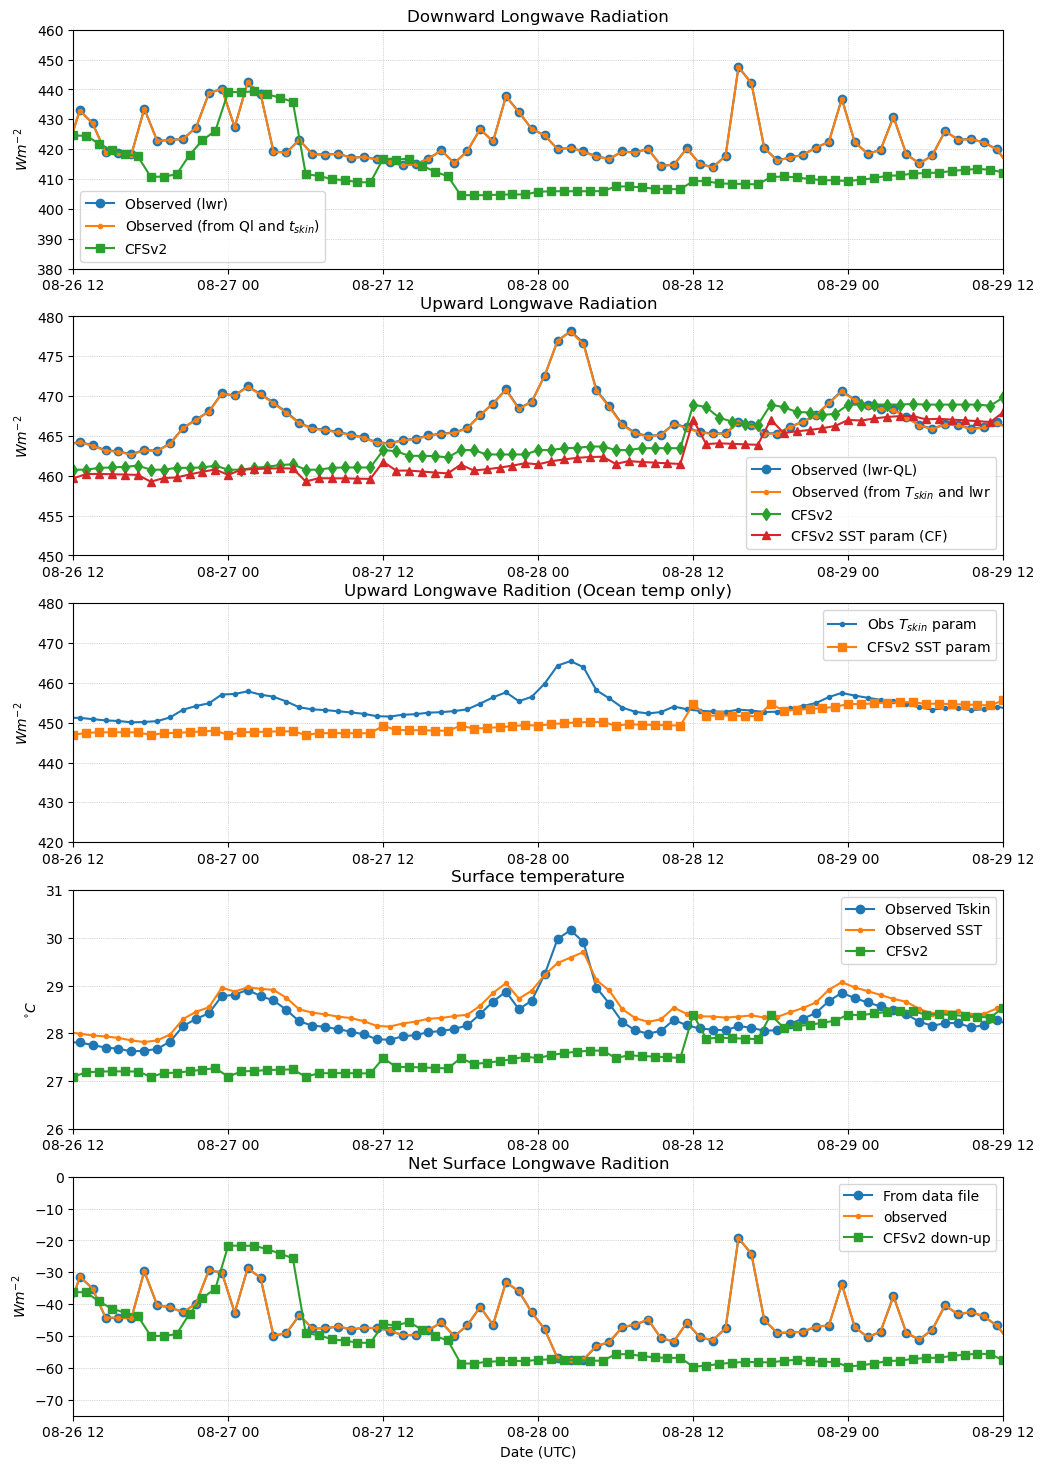

In [10]:
# Plot an arbitrary three-day period
fig, ax = plt.subplots( figsize = ( 12, 18 ), nrows = 5, ncols = 1 )

ax[0].plot(otime,lwr,'o-',label='Observed (lwr)')
ax[0].plot(otime,Ql/epsilon+sigma*(tskin+273.15)**4,'.-',label='Observed (from Ql and $t_{skin}$)')
ax[0].plot(mtime,cfs_ql_down,'s-',label='CFSv2')
ax[0].set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax[0].set_ylim(380,460)
ax[0].set_title('Downward Longwave Radiation')
ax[0].set_ylabel('$W m^{-2}$')
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].plot(otime,Ql_up,'o-',label='Observed (lwr-QL)')
ax[1].plot(otime,Ql_up2,'.-',label='Observed (from $T_{skin}$ and lwr')
ax[1].plot(mtime,cfs_ql_up,'d-',label='CFSv2')
ax[1].plot(mtime,cfs_ql_up2,'^-',label='CFSv2 SST param (CF)')
ax[1].set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax[1].set_ylim(450,480)
ax[1].set_title('Upward Longwave Radiation')
ax[1].set_ylabel('$W m^{-2}$')
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=0.5)

ax[2].plot(otime,Ql_up1,'.-',label='Obs $T_{skin}$ param')
ax[2].plot(mtime,cfs_ql_up1,'s-',label='CFSv2 SST param')
ax[2].set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax[2].set_ylim(420,480)
ax[2].set_title('Upward Longwave Radition (Ocean temp only)')
ax[2].set_ylabel('$W m^{-2}$')
ax[2].legend()
ax[2].grid(linestyle=':', linewidth=0.5)

ax[3].plot(otime,tskin,'o-',label='Observed Tskin')
ax[3].plot(otime,sst,'.-',label='Observed SST')
ax[3].plot(mtime,cfs_sst-273.15,'s-',label='CFSv2')
ax[3].set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax[3].set_ylim(26,31)
ax[3].set_title('Surface temperature')
ax[3].set_ylabel('$^{\circ}C$')
ax[3].legend()
ax[3].grid(linestyle=':', linewidth=0.5)

ax[4].plot(otime,Ql,'o-',label='From data file')
ax[4].plot(otime,epsilon*(lwr-sigma*(tskin+273.15)**4),'.-',label='observed')
ax[4].plot(mtime,cfs_ql_down-cfs_ql_up,'s-',label='CFSv2 down-up')
ax[4].set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax[4].set_ylim(-75,0)
ax[4].set_title('Net Surface Longwave Radition')
ax[4].set_xlabel('Date (UTC)')
ax[4].set_ylabel('$W m^{-2}$')
ax[4].legend()
ax[4].grid(linestyle=':', linewidth=0.5)

plt.savefig('./output/' + site + '_QL.png',format='png',facecolor='white')

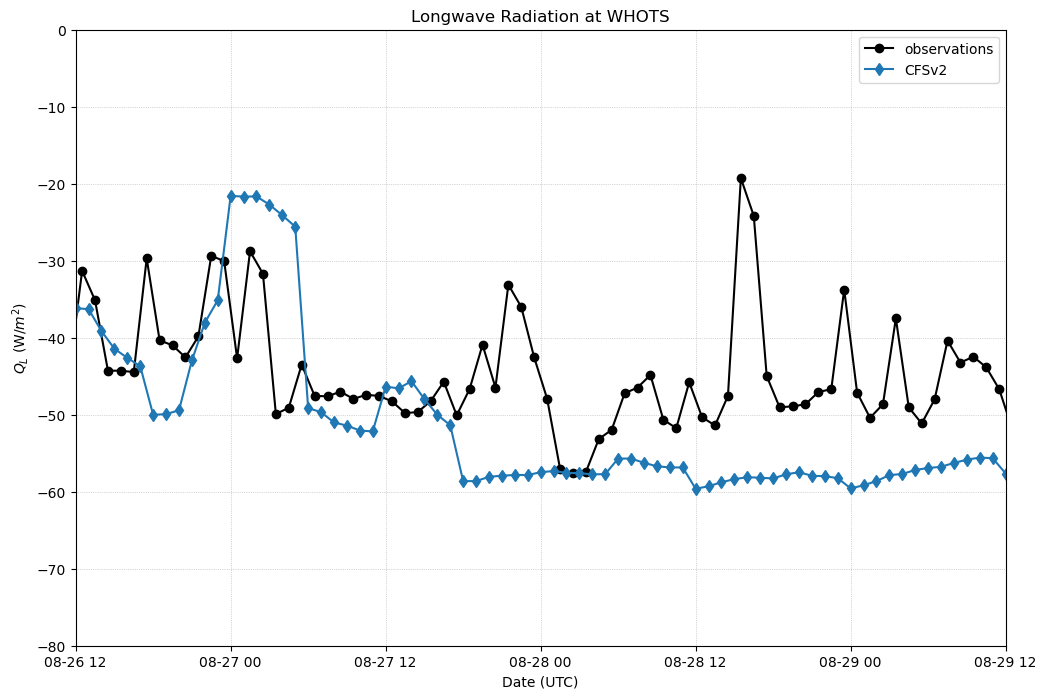

In [11]:
# Plot net longwave
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(otime,Ql,'ko-',label='observations')
ax.plot(mtime,cfs_ql_down-cfs_ql_up,'d-',label='CFSv2')
ax.set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax.set_ylim([-80, 0])
ax.set_title('Longwave Radiation at WHOTS')
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{L}$ (W/$m^2$)')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)

plt.savefig('./output/' + site + '_QL2.png',format='png',facecolor='white')

# 3. Compare observations to model (longterm)

In [12]:
# add model and obs to DataFrames
model_data =  pd.DataFrame({'Time':mtime, 'cfs_ql': cfs_ql_down-cfs_ql_up, 'cfs_up': cfs_ql_up, 
                     'cfs_down': cfs_ql_down, 'cfs_up1': cfs_ql_up1, 'cfs_up2': cfs_ql_up2,
                     'cfs_sst': cfs_sst, 'cfs_press': cfs_press, 'cfs_qa': cfs_qa,
                     'cfs_tair': cfs_tair})
obs_data = pd.DataFrame({'Time':otime, 'obs_ql': Ql, 'obs_up': Ql_up, 'obs_down': lwr,
                      'obs_ql_up1': Ql_up1, 'obs_ql_up2': Ql_up2, 'obs_skin': tskin,
                      'obs_press': press, 'obs_qa': qa, 'obs_tair1': tair1, 'obs_tair2':tair2})

# now combine to single DataFrame
AllData = pd.merge_asof(obs_data,model_data,on='Time', tolerance=pd.Timedelta('60 minute'))

Correlation CFS net to observed: 0.4410221820267117
Correlation CFS SST to observed skin temperature: 0.963941610727432
Correlation CFS upward to Obs upward: 0.9548769353921691
Correlation CFS downward to obs downward: 0.5335362028163225
Correlation obs upward to downward: 0.535345596625054
Correlation CFS upward to downward: 0.380378442718995


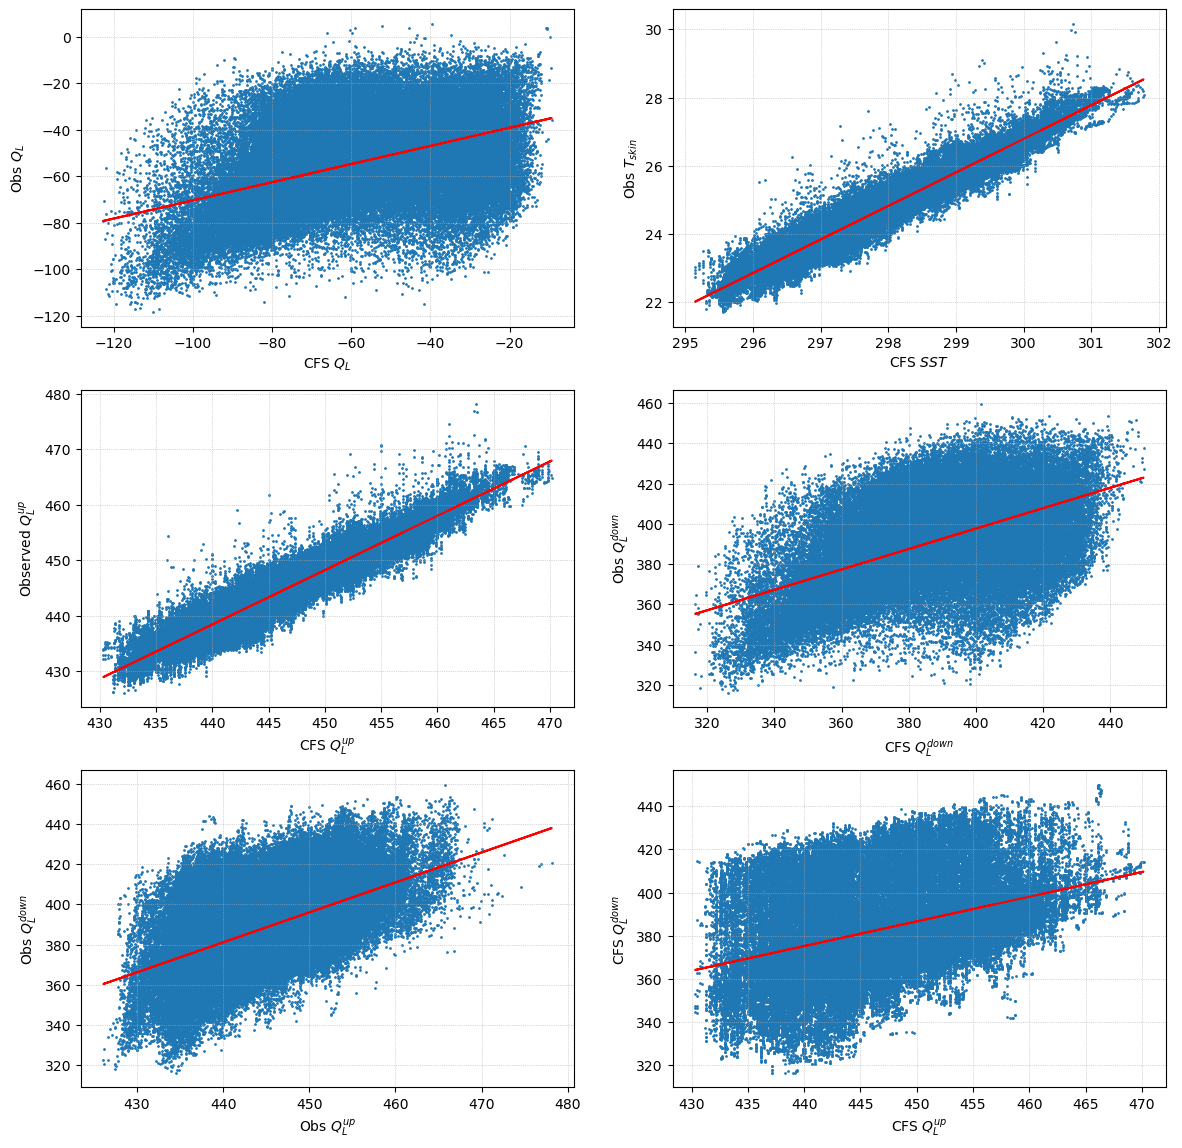

In [13]:
time = AllData['Time']
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(14,14))

#   1. Upper left figure is net longwave from model compared to obs
x = AllData['cfs_ql']
y = AllData['obs_ql']
ax[0,0].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,0].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS net to observed: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[0,0].plot(x1,y1,color='black')

ax[0,0].set_xlabel('CFS $Q_{L}$')
ax[0,0].set_ylabel('Obs $Q_{L}$')
#ax[0,0].set_title(site)
ax[0,0].grid(linestyle=':', linewidth=0.5)

#   2. Upper right figure is model SST compared to obs tskin
x = AllData['cfs_sst']
y = AllData['obs_skin']
ax[0,1].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[0,1].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS SST to observed skin temperature: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[0,1].plot(x1,y1,color='black')

ax[0,1].set_xlabel('CFS $SST$')
ax[0,1].set_ylabel('Obs $T_{skin}$')
#ax[0,1].set_title(site)
ax[0,1].grid(linestyle=':', linewidth=0.5)
    
#   3. Middle left figure is model upward vs. obs upward
#   using model SST
x = AllData['cfs_up']
y = AllData['obs_up']
ax[1,0].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,0].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS upward to Obs upward: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[1,0].plot(x1,y1,color='black')

ax[1,0].set_xlabel('CFS $Q_{L}^{up}$')
ax[1,0].set_ylabel('Observed $Q_{L}^{up}$')
#ax[1,0].set_title(site)
ax[1,0].grid(linestyle=':', linewidth=0.5)
    
#   4. Middle right is model downward vs obs downward
x = AllData['cfs_down']
y = AllData['obs_down']
ax[1,1].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[1,1].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS downward to obs downward: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[1,1].plot(x1,y1,color='black')

ax[1,1].set_xlabel('CFS $Q_{L}^{down}$')
ax[1,1].set_ylabel('Obs $Q_{L}^{down}$')
#ax[1,1].set_title(site)
ax[1,1].grid(linestyle=':', linewidth=0.5)

#   5.  Lower left is observed upward vs downward
x = AllData['obs_up']
y = AllData['obs_down']
ax[2,0].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[2,0].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation obs upward to downward: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[2,0].plot(x1,y1,color='black')

ax[2,0].set_xlabel('Obs $Q_{L}^{up}$')
ax[2,0].set_ylabel('Obs $Q_{L}^{down}$')
#ax[2,0].set_title(site)
ax[2,0].grid(linestyle=':', linewidth=0.5)

#   6.  Lower right is model upward to model downward
x = AllData['cfs_up']
y = AllData['cfs_down']
ax[2,1].scatter(x,y,s=1,rasterized=True)

#   do linear regression fit (check for NaN's first)
idx = np.isfinite(x) & np.isfinite(y)
B = np.polyfit(x[idx],y[idx],1)
A = np.polyval(B,x)
ax[2,1].plot(x,A,color='red')

#   find correlation coefficient (slope of Z_x vs Z_y)
Zx = ( x[idx] - np.mean(x[idx]) ) / np.std(x[idx]) 
Zy = ( y[idx] - np.mean(y[idx]) ) / np.std(y[idx]) 
C = np.polyfit(Zx,Zy,1)
print('Correlation CFS upward to downward: ' + str(C[0]) )
#   draw 1:1 line in black
#x1, y1 = [minax,maxax],[minax,maxax]
#ax[2,1].plot(x1,y1,color='black')

ax[2,1].set_xlabel('CFS $Q_{L}^{up}$')
ax[2,1].set_ylabel('CFS $Q_{L}^{down}$')
#ax[2,1].set_title(site)
ax[2,1].grid(linestyle=':', linewidth=0.5)

# 4. Estimation of cloud cover
Chris Fairall provided matlab code to compute cloud cover based on the difference between observed and theoretical values of surface longwave radiation.

As noted above, upward longwave radiation can be computed from the observed surface temperature ($T_{skin}$).  Using the ORS provided net longwave ($Q_{L}$), the downward component can be computed as:

\begin{eqnarray}
Q_{L}^{Down} = \frac{Q_{L}^{Net}}{\epsilon} + \sigma \: T_{skin}^{4}
\end{eqnarray}

The cloud fraction is then a ratio of the downward heat flux $Q_{L}^{Down}$ as measured, $Q_{L}^{Down}$ under clear skies ($Q_L^{Clear}$), and $Q_{L}^{Down}$ under cloudy skies ($Q_L^{Cloudy}$).  Clear-sky downward longwave radiation can be estimated using the same equation as above using air temperature ($T_{air}$) and emissivity instead of ocean temperature and emissivity:

\begin{eqnarray}
Q_{L}^{Clear} = \phi \: \sigma \: T_{air}^{4}
\end{eqnarray}

with,
\begin{eqnarray}
\phi = 0.77 + 0.006 \sqrt{q_a} + 0.0063 \frac{q_a}{5}
\end{eqnarray}

Note here that $\frac{q_a}{5}$ is an approximation of the integrated water vapor.  The longwave in the presence of clouds is given by a best fit (NOTE this is specific for NTAS...):

\begin{eqnarray}
Q_{L}^{Cloudy} = 395 + 10.0 sin(t)
\end{eqnarray}

where $t$ is the day of the year.  Downward longwave under clouds can also be estimated with dew point temperature,

\begin{eqnarray}
Q_{L}^{Dew} = \sigma \: T_{dew}^{4}
\end{eqnarray}

where $T_{dew}$ is given by $241.0 * \frac{z}{17.502-z}$, with

\begin{eqnarray}
z = log \left[ \frac{ \frac{P q_a}{0.622 + 0.378 q_a}}{6.112(1.0007 + 3.46x10^{-6}P)} \right]
\end{eqnarray}

where $q_a$ is specific humdity (in kg/kg) and $P$ is atmospheric pressure.  Finally, the cloud fraction ($f_c$) can then be computed as the ratio of the downward, longwave under clear skies and cloudy (computed two ways):

\begin{eqnarray}
f_c^1 = \frac{Q_L^{Down} - Q_L^{Clear}}{Q_L^{Cloudy} - Q_L^{Clear}}
\end{eqnarray}

.

\begin{eqnarray}
f_c^2 = \frac{Q_L^{Down} - Q_L^{Clear}}{Q_L^{Dew} - Q_L^{Clear}}
\end{eqnarray}

For example, if the skies are 100% covered by clouds, $Q_L^{Down} = Q_L^{Cloudy}$ and the cloud fraction becomes 1.  Alternately, with completely cloud-free skies, the ratio is zero.

<font color='red'>
The parameter $\phi$ appears to also be computed using
\begin{eqnarray}
\phi_{1} = 0.52 + \frac{0.13}{60} \theta + \left(0.082 - \frac{0.03}{60} \theta \right)
\sqrt{q_a} + 0.0084 \frac{q_a}{5} - 0.0451
\end{eqnarray}

but this is commented out in the code.
</font>

## Compute cloud fraction
This is adapted from Chris Fairall's code...

| Variable       | Description                                    | CF code | Obs  |
|----------------|------------------------------------------------|---------|------|
| $Q_L^{Net}$    | Net longwave radiation                         | rln     | Ql   |
| $Q_L^{Down}$   | Downward longwave radiation                    | rl      | LW   |
| $Q_L^{Clear}$  | Clear-sky downward longwave radiation          | rlclr   | .    |
| $Q_L^{Cloudy}$ | Downward longwave radiation under cloudy skies | rlcld   | .    |
| $Q_L^{Dew}$    | Downward longwave radiation under cloudy skies | rlcld2  | .    |
| $f_c^1$        | Cloud fraction based on $Q_L^{Cloudy}$         | .       | .    |
| $f_c^2$        | Cloud fraction based on $Q_L^{Dew}$            | CF      | .    |
| $T_{skin}$     | Ocean surface skin temperature                 | ts      | tskin|
| $T_{air1}$     | 2m air temperature                             | ta      | ta_h |
| $T_{air2}$     | surface air temperature                        | ta      | atmp |
| $\phi$         | emissivity of air                              | epss    | .    |
| $\phi_1$       | emissivity of air (alternate)                  | eps     | .    |
| $q_a$          | specific humidity (kg/kg)                      | qa      | qq_h |
| $P$            | surface pressure (mb)                          | press   | bpr  |
| $T_{dew}$      | dew point temperature                          | td      | .    |



In [32]:
# C. Fairall's code to compute cloud fraction
# Input:
#   qa...........specific humidity in kg/kg
#   vap..........vapor (CF sets to qa/5)
#   press........atmospheric pressure (mb)
#   ta...........surface (2m) air temperature
#   to...........ocean temperature (SST or skin)
#   ql_net.......downward longwave radiation (measured by buoy)
# Output:
#   ql_clear.....downward longwave heat under clear skies
#   ql_cloudy1...downward longwave heat under cloudy skies (based on time of day only)
#   ql_cloudy2a..downward longwave heat under cloudy skies (based on dew point temperature with constant P)
#   ql_cloudy2b..downward longwave heat under cloudy skies (based on dew point temperature with observed P)
#   cloud_frac1..cloud fraction based on ql_cloudy1
#   cloud_frac2a.cloud fraction based on ql_cloudy2a
#   cloud_frac2b.cloud fraction based on ql_cloudy2b

def cloud_frac(qa,vap,press,ta,to,ql_net):
    # note
    # Stefan-Boltzmann and emissivity
    sigma = 5.67e-8
    epss = ( 0.77 + 0.006 * np.sqrt(qa) + 0.0063 * vap )
    
    # convert temperature to Kelvin
    to = to + 273.15
    ta = ta + 273.15
    
    # compute incoming longwave (ql_in) from the buoy-reported net longwave (ql_net) and
    # surface temperature
    ql_out = sigma * to**4
    ql_in = ql_net / epsilon + ql_out
    ql_clear = epss * sigma * ta**4
    
    # compute QL under cloudy skies from C. Fairall's parameterization
    t = AllData['Time'].dt.dayofyear
    ql_cloudy1 = 395.0 + 10.0 * np.sin(t/365.25*np.pi/180.0)
    
    # compute QL under cloudy skies using dew-point temperature
    e1 = press * qa / 1000.0 / ( 0.622 + 0.378 * qa / 1000.0 )
    e2 = 1010.0 * qa / 1000.0 / ( 0.622 + 0.378 * qa / 1000.0 )
    z1 = np.log( e1 / (1.0007 + 3.46e-6 * press ) / 6.112 )
    z2 = np.log( e2 / (1.0007 + 3.46e-6 * 1010.0 ) / 6.112 )
    
    td1 = 241.0 * z1 / ( 17.502 - z1 )
    td2 = 241.0 * z2 / ( 17.502 - z2 )
    
    ql_cloudy2a = sigma * ( td1 + 273.15 )**4
    ql_cloudy2b = sigma * ( td2 + 273.15 )**4
    
    cloud_frac1 = ( ql_in - ql_clear ) / ( ql_cloudy1 - ql_clear )
    cloud_frac2a = ( ql_in - ql_clear ) / ( ql_cloudy2a - ql_clear )
    cloud_frac2b = ( ql_in - ql_clear ) / ( ql_cloudy2b - ql_clear )
    
    return ql_clear, ql_cloudy1, ql_cloudy2a, ql_cloudy2b, cloud_frac1, cloud_frac2a, cloud_frac2b

In [33]:
vap = AllData['obs_qa']/5.0

# here I use "obs_tair2" which is the computed variable "atmp"; I think this is surface air temp
# while "obs_tair1" is the measured variable "ta_h" that I think is 2 meter temperature
ql_clear, ql_cloudy1, ql_cloudy2a, ql_cloudy2b, cloud_frac1, cloud_frac2a, cloud_frac2b = cloud_frac(AllData['obs_qa'],
            vap,AllData['obs_press'],AllData['obs_tair2'],AllData['obs_skin'],AllData['obs_ql'])


<font color=red>
Notes:

 1. Not sure why $\phi_1$ is a function of latitude ($\theta$)
    
 2. Unsure about the parameterization of $Q_L^{Cloudy}$
 
 3. The version of CF's script does not use $\phi_1$; it is commented out
 
 4. The version of CF's script uses $Q_L^{Dew}$ in the calculation of cloud fraction, not $Q_L^{Cloudy}$
 
 5. The variables $Q_L^{Down}$ is given as LW in the MLTS file, but this is not used
 
 6. Related, not sure why buoy obs for pressure and humidity are also not used (set to constant)
 
 7. Just a reminder, the model (CFS) has $Q_L^{Down}$, $Q_L^{Up}$, $T_{air}$ and $q_a$ as dlwsfc, ulwsfc, tmp2m and q2m
</font>

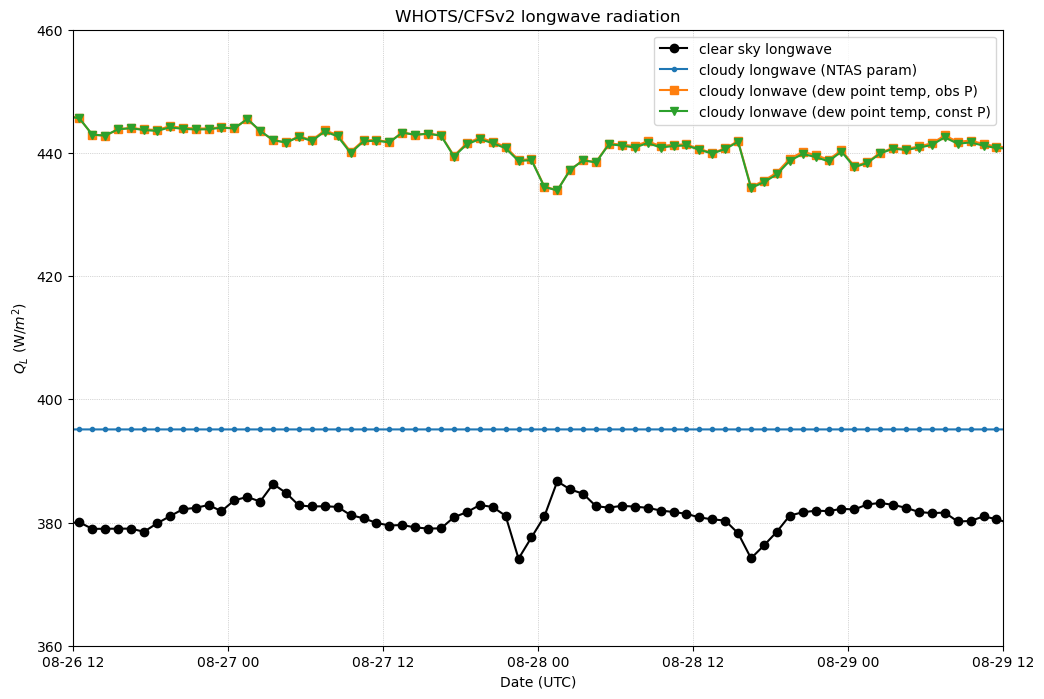

In [34]:
fig, ax = plt.subplots( figsize = ( 12, 8 ) )
ax.plot(otime,ql_clear,'ko-',label='clear sky longwave')
ax.plot(otime,ql_cloudy1, '.-',label='cloudy longwave (NTAS param)')
ax.plot(otime,ql_cloudy2a, 's-',label='cloudy lonwave (dew point temp, obs P)')
ax.plot(otime,ql_cloudy2b, 'v-',label='cloudy lonwave (dew point temp, const P)')
ax.set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
ax.set_ylim([360,460])
ax.set_title('WHOTS/CFSv2 longwave radiation')
ax.set_xlabel('Date (UTC)')
ax.set_ylabel('$Q_{L}$ (W/$m^2$)')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)

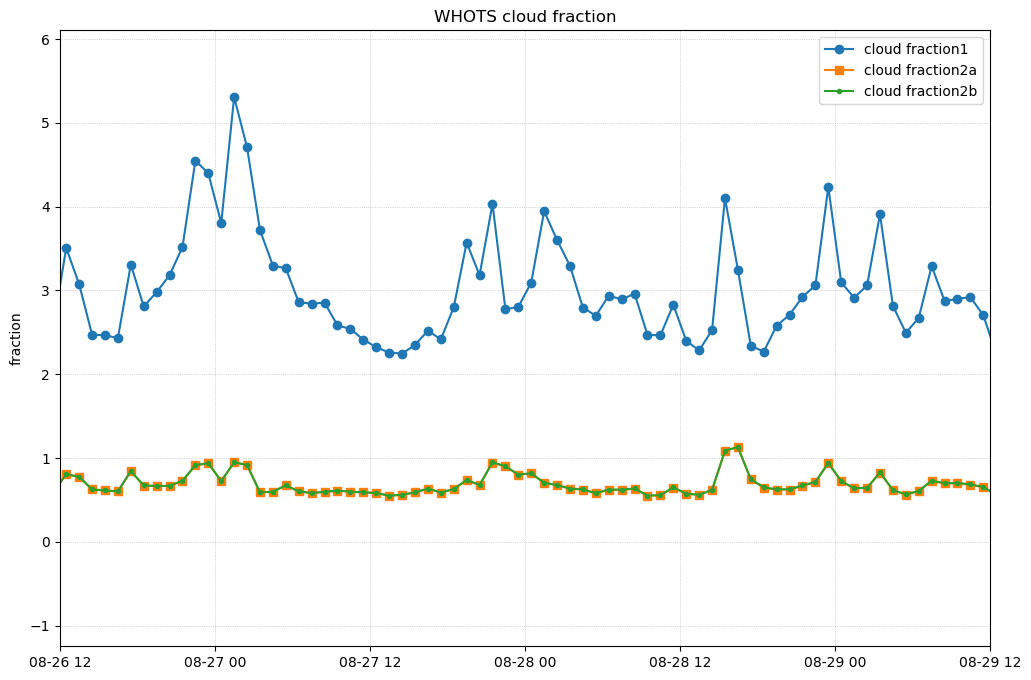

In [35]:
fig, ax = plt.subplots( figsize = ( 12, 8 ), nrows = 1, ncols = 1 )

ax.plot(otime,cloud_frac1,'o-',label='cloud fraction1')
ax.plot(otime,cloud_frac2a,'s-',label='cloud fraction2a')
ax.plot(otime,cloud_frac2b,'.-',label='cloud fraction2b')
ax.set_xlim([datetime(2015, 8, 26, 12), datetime(2015, 8, 29, 12)])
#ax[1].set_ylim(0,1)
ax.set_title('WHOTS cloud fraction')
ax.set_ylabel('fraction')
ax.legend()
ax.grid(linestyle=':', linewidth=0.5)

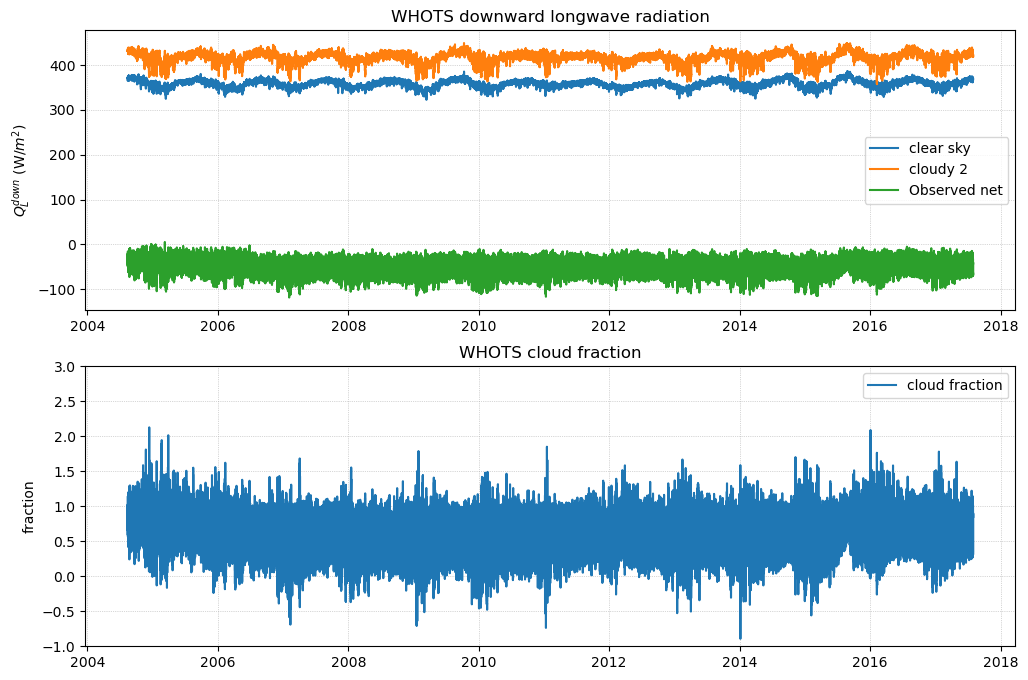

In [42]:
fig, ax = plt.subplots( figsize = ( 12, 8 ), nrows = 2, ncols = 1 )

ax[0].plot(otime,ql_clear,label='clear sky')
#ax[0].plot(otime,ql_cloudy1,label='cloudy 1')
#ax[0].plot(otime,ql_cloudy2a,label='cloudy 2')
ax[0].plot(otime,ql_cloudy2b,label='cloudy 2')
ax[0].set_title('WHOTS downward longwave radiation')
ax[0].set_ylabel('$Q_{L}^{down}$ (W/$m^2$)')
ax[0].legend()
ax[0].grid(linestyle=':', linewidth=0.5)

ax[1].plot(otime,cloud_frac2a,label='cloud fraction')
ax[1].set_ylim(-1,3)
ax[1].set_title('WHOTS cloud fraction')
ax[1].set_ylabel('fraction')
ax[1].legend()
ax[1].grid(linestyle=':', linewidth=0.5)